In [3]:
import pandas_datareader.data as web
import app
#from app import server
import dash
import dash_html_components as html
import dash_core_components as dcc
from dash.dependencies import Input, Output
from datetime import datetime
import dash_table
import pandas as pd
import datetime 
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import numpy as np
import plotly.express as px


In [4]:
import os
from pathlib import Path
import requests
import datetime
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline
from pprint import pprint as pp
from alpha_vantage.timeseries import TimeSeries
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from numpy.random import seed
seed(23)
from tensorflow import random

random.set_seed(32)

import livelossplot
from livelossplot import PlotLossesKeras
from alpha_vantage.timeseries import TimeSeries
from jupyter_plotly_dash import JupyterDash
from tensorflow import keras
from IPython.display import clear_output

In [14]:
class TrainingPlot(keras.callbacks.Callback):
    
    # This function is called when the training begins
    def on_train_begin(self, logs={}):
        # Initialize the lists for holding the logs, losses and accuracies
        self.losses = []
        self.acc = []
        self.val_losses = []
        self.val_acc = []
        self.logs = []
        
 #   def on_train_end(self, logs={}):
        #calculate total time
   #     self.train_dur = time.time()-self.train_start
 #       self.log.write("\n\nTotal duration: " + str(self.train_dur) + " seconds\n")
  #      self.log.write("*"*100+"\n")
  #      self.log.close()
    #    print("train end logs:", logs)
   #     self.__save_plots(logs)
        #write time to a file
   #     return
    
    
    # This function is called at the end of each epoch
    def on_epoch_end(self, epoch, logs={}):
        
        # Append the logs, losses and accuracies to the lists
        self.logs.append(logs)
        self.losses.append(logs.get('loss'))
        self.acc.append(logs.get('acc'))
        self.val_losses.append(logs.get('val_loss'))
        self.val_acc.append(logs.get('val_acc'))
        
        # Before plotting ensure at least 2 epochs have passed
        if len(self.losses) > 1:
            
            # Clear the previous plot
            clear_output(wait=True)
            N = np.arange(0, len(self.losses))
            
            # You can chose the style of your preference
            # print(plt.style.available) to see the available options
            plt.style.use("seaborn")
            
            # Plot train loss, train acc, val loss and val acc against epochs passed
            plt.figure()
            plt.plot(N, self.losses, label = "train_loss")
            plt.plot(N, self.acc, label = "train_acc")
            plt.plot(N, self.val_losses, label = "val_loss")
            plt.plot(N, self.val_acc, label = "val_acc")
            plt.title("Training Loss and Accuracy [Epoch {}]".format(epoch))
            plt.xlabel("Epoch #")
            plt.ylabel("Loss/Accuracy")
            plt.legend()
            plt.show()       
plot_losses = TrainingPlot()

In [5]:
sp = pd.read_csv('resources/Characteristics.csv',index_col='Ticker')
sp.head()

,Sector,Sub Industry,Name,Price,Dividend Yield,Market Cap ($M),Forward P/E Ratio,Payout Ratio,Beta
Ticker,,,,,,,,,
A,Health Care,Health Care Equipment,"Agilent Technologies, Inc.",74.56,0.009055,2.297920e+04,30.44,0.274331,0.960773
AAL,Industrials,Airlines,"American Airlines Group, Inc.",9.81,0.037594,4.499603e+03,-5.28,-0.215088,1.298470
AAP,Consumer Discretionary,Automotive Retail,"Advance Auto Parts, Inc.",120.11,0.002058,8.055087e+03,17.49,0.034951,0.997614
AAPL,Information Technology,"Technology Hardware, Storage & Peripherals","Apple, Inc.",293.54,0.010655,1.264820e+06,22.79,0.239474,1.160621
ABBV,Health Care,Pharmaceuticals,"AbbVie, Inc.",81.86,0.054322,1.223273e+05,NaN,NaN,0.790977


In [6]:
end = datetime.datetime.now()
start = datetime.datetime(end.year - 5, end.month , end.day)

ticker_list = sp.index.to_list()


button_list = list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])

In [7]:
def window_data(df, window, feature_col_number, target_col_number):
    """
    This function accepts the column number for the features (X) and the target (y).
    It chunks the data up with a rolling window of Xt - window to predict Xt.
    It returns two numpy arrays of X and y.
    """
    X = []
    y = []
    for i in range(len(df) - window - 1):
        features = df.iloc[i : (i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [8]:
def get_stock_data(ticker):
    #return ((1 + web.DataReader(ticker, 'yahoo', start, end)['Close'].pct_change().dropna().sort_index()).cumprod()-1).reset_index().rename({'Close':ticker},axis=1)
    return web.DataReader(ticker, 'yahoo', start, end)['Close'].reset_index().rename({'Close':ticker},axis=1)


In [31]:
def get_time_series_figure(ticker):
    global df, button
    plot = []
    if ticker==None or len(ticker)==0:
        return go.Figure(layout={
            'template':'plotly_dark',
            'plot_bgcolor':"#2E2D2C", 'paper_bgcolor':"#2E2D2C",
            'title': 'Select a Stock'})
    
  #  for ticker in val:
    else:
        tickers_df = web.DataReader(ticker, 'yahoo', start, end)['Close'].reset_index().sort_values(by='Date', ascending = False)

        window_size = 60
        feature_column = 1
        target_column = 1

        X, y = window_data(tickers_df, window_size, feature_column, target_column)

        split = int(0.80 * len(X))
        X_train = X[: split - 1]
        X_test = X[split:]
        y_train = y[: split - 1]
        y_test = y[split:]

        scaler = MinMaxScaler()
        scaler.fit(X)
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)
        scaler.fit(y)
        y_train = scaler.transform(y_train)
        y_test = scaler.transform(y_test)

        X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
        X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

        # a. Define the LSTM RNN model.
        model = Sequential()

        # Initial model setup
        number_units = 60
        dropout_fraction = 0.2

        model.add(LSTM(
        units=number_units,
        return_sequences=True,
        input_shape=(X_train.shape[1], 1))
            )
        model.add(Dropout(dropout_fraction))
        model.add(LSTM(units=number_units, return_sequences=True))
        model.add(Dropout(dropout_fraction))
        model.add(LSTM(units=number_units))
        model.add(Dropout(dropout_fraction))
        model.add(Dense(1))
        model.compile(loss = "mean_absolute_error", optimizer = "adam", metrics = ['accuracy'])

        # Define the Keras TensorBoard callback.
        #logdir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
       # tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

        model.fit(X_train, y_train,
                  epochs=10,
                  shuffle=False,
                  batch_size=30,
                  #validation_data=(X_test, y_test),
                  #callbacks=[plot_losses]
                           )

        predicted = model.predict(X_test)
        predicted_prices = scaler.inverse_transform(predicted)
        real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))
        stocks = pd.DataFrame({
            "Actual": real_prices.ravel(),
            "Predicted": predicted_prices.ravel()})

        trace_actual = go.Scatter(x=stocks.index, y=stocks['Actual'], name="Actual", )
        trace_predicted = go.Scatter(x=stocks.index, y=stocks['Predicted'], name="Predicted", )

        fig = go.Figure([trace_actual, trace_predicted]) 
        fig.update_xaxes(rangeselector=dict(buttons=button_list, bgcolor='blue'), rangeslider=dict(visible=False, bgcolor='white')
                            )
        fig.layout.template='plotly_dark'
        fig.layout.title={'text': f'{ticker} Actual vs Predicted Stock Prices', 'font': {'color': 'white'}, 
                         }
        fig.update_layout(plot_bgcolor="#2E2D2C", paper_bgcolor="#2E2D2C")
    
    return fig

In [32]:
from jupyter_plotly_dash import JupyterDash

import dash
import dash_html_components as html
import dash_core_components as dcc

app = JupyterDash('SimpleExample')


#app = dash.Dash(__name__, )
app.layout = html.Div([
    html.H2('Recurrent Neural Networks'),
    
    html.Div([dcc.Dropdown(
        id='stock-dropdown',
        options=[{'label': i,'value': i} for i in ticker_list],
    #    multi=True,
        placeholder="Select a stock",
        style={'color':'black'})],
    style={'width': '45%','display': 'inline-block'}),
    html.Div(id='close-stock-container'),
    
])            



@app.callback(
    dash.dependencies.Output('close-stock-container', 'children'),
    [dash.dependencies.Input('stock-dropdown', 'value')])
def update_output(selected_value):
    
    return [dcc.Graph(figure=get_time_series_figure(selected_value))]

app

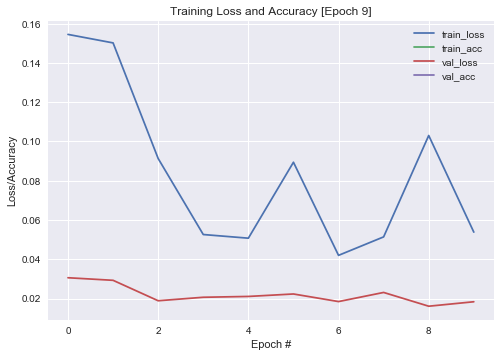

957/957 [==============================] - 1s 574us/sample - loss: 0.0538 - accuracy: 0.0010 - val_loss: 0.0183 - val_accuracy: 0.0042


In [23]:
der = get_time_series_figure("AAPL")
der

In [63]:


tickers_df = get_stock_data("AAPL")
tickers_df

,Date,AAPL
0,2015-07-10,123.279999
1,2015-07-13,125.660004
2,2015-07-14,125.610001
3,2015-07-15,126.820000
4,2015-07-16,128.509995
...,...,...
1255,2020-07-06,373.850006
1256,2020-07-07,372.690002
1257,2020-07-08,381.369995
1258,2020-07-09,383.010010


# Random Forest